# Diagnostic couverture mobile (Tanger-Tétouan)

Ce notebook transforme le fichier `morocco_towers.csv` en carte interactive et statistiques pour repérer les zones de fracture numérique.



Plan appliqué :

1. Pré-traitement : filtre géographique, nettoyage des mesures, normalisation des technologies.

2. Grillage spatial (1 km) : comptage Class_A (4G/5G) vs Class_B (2G/3G) et statut de couverture.

3. Optionnel ML : DBSCAN sur les antennes rapides pour isoler les zones en dehors des clusters modernes.

4. Visualisation : carte HTML interactive + rapport console.



Paramètres (adaptables) : bbox Tanger-Tétouan, seuil d'échantillons ≥ 10, portée 0 < range ≤ 100 000 m, grille 1 km.


In [ ]:
# Imports et paramètres globaux

import pandas as pd
import numpy as np
from pathlib import Path
import math

# Chemin vers les données brutes
DATA_PATH = Path("morocco_towers.csv")

# Zone d'étude : Tanger-Tétouan
BBOX = {
    "lat_min": 34.5,
    "lat_max": 36.0,
    "lon_min": -6.5,
    "lon_max": -4.5,
}

# Paramètres métier
GRID_KM = 1.0  # taille de maille (km)
SAMPLE_MIN = 10  # échantillons minimum
RANGE_MAX = 100_000  # portée maximale (m)
ACTIVE_YEAR_MIN = 2015  # garde les antennes mises à jour depuis cette année (None pour désactiver)
LAT_REF = 35.7  # latitude de référence pour la correction cosinus

# Regroupement techno
TECH_FAST = {"LTE", "LTE-ADVANCED", "LTE ADVANCED", "5G", "NR"}
TECH_BASE = {"GSM", "UMTS", "CDMA", "WCDMA", "HSPA", "HSPA+"}


## Phase 1 : Pré-traitement et nettoyage

- Filtrer la bbox Tanger-Tétouan.

- Supprimer mesures douteuses : `sam < 10`, `range <= 0` ou `range > 100 000`.

- Normaliser la colonne `radio` en deux classes : `Class_A` (rapide) vs `Class_B` (base).

- Conserver uniquement les antennes avec coordonnées valides.


In [84]:
# Chargement et nettoyage

df_raw = pd.read_csv(DATA_PATH)
df = df_raw.copy()
df.columns = [c.lower() for c in df.columns]

# Conversion en datetime pour la fraîcheur des données (conserve la colonne d'origine pour export)
df["updated_dt"] = pd.to_datetime(df.get("updated"), unit="s", errors="coerce")
if ACTIVE_YEAR_MIN is not None:
    df_active = df[df["updated_dt"].dt.year >= ACTIVE_YEAR_MIN].copy()
else:
    df_active = df.copy()

# Conversion numérique des coordonnées
df_active["lat"] = pd.to_numeric(df_active.get("lat"), errors="coerce")
df_active["lon"] = pd.to_numeric(df_active.get("lon"), errors="coerce")
df_active["range"] = pd.to_numeric(df_active.get("range"), errors="coerce")
df_active["sam"] = pd.to_numeric(df_active.get("sam"), errors="coerce")

# Filtres géographiques et qualité
bbox_mask = (
    df_active["lat"].between(BBOX["lat_min"], BBOX["lat_max"]) &
    df_active["lon"].between(BBOX["lon_min"], BBOX["lon_max"])
)
range_mask = (df_active["range"] > 0) & (df_active["range"] <= RANGE_MAX)
sample_mask = df_active["sam"].fillna(0) >= SAMPLE_MIN

df_clean = df_active.loc[bbox_mask & range_mask & sample_mask].copy()

# Normalisation techno
radio_norm = df_clean["radio"].str.upper().str.strip()
df_clean["Tech_Class"] = np.select(
    condlist=[radio_norm.isin(TECH_FAST), radio_norm.isin(TECH_BASE)],
    choicelist=["Class_A", "Class_B"],
    default=None,
)
df_clean = df_clean.dropna(subset=["Tech_Class", "lat", "lon"])

print(f"Entrées brutes : {len(df_raw):,}")
print(f"Antennes actives (>= {ACTIVE_YEAR_MIN}) : {len(df_active):,}")
print(f"Après filtres bbox + qualité : {len(df_clean):,}")
print(df_clean["Tech_Class"].value_counts())


Entrées brutes : 115,092
Antennes actives (>= 2015) : 107,472
Après filtres bbox + qualité : 1,515
Tech_Class
Class_B    996
Class_A    519
Name: count, dtype: int64



=== VISUALISATION 1 : Répartition Technologique ===



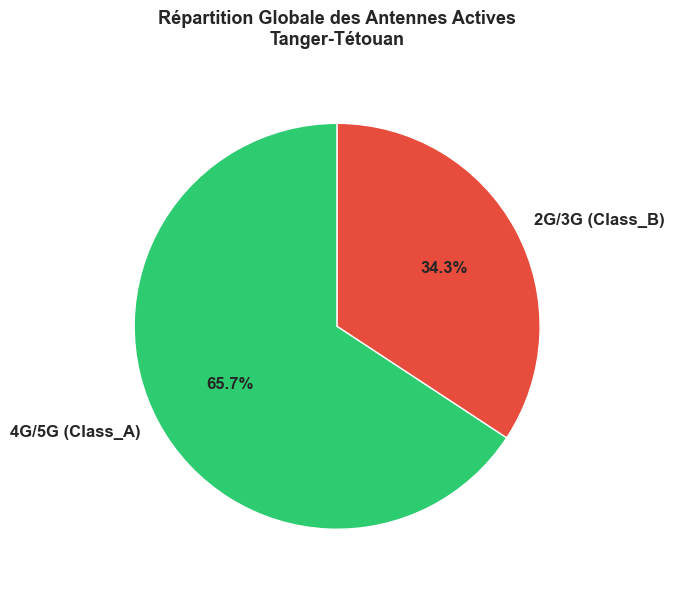

✅ Fig1_Repartition_Global.png sauvegardée



In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

# Graphique 1 : Distribution des technologies après nettoyage
print("\n=== VISUALISATION 1 : Répartition Technologique ===\n")
fig, ax = plt.subplots(figsize=(8, 6))
data_pie = df_clean['Tech_Class'].value_counts()
colors_pie = ['#2ecc71', '#e74c3c']  # Vert 4G/5G, Rouge 2G/3G
wedges, texts, autotexts = ax.pie(
    data_pie,
    labels=['4G/5G (Class_A)', '2G/3G (Class_B)'],
    autopct='%1.1f%%',
    colors=colors_pie,
    startangle=90,
    textprops={'fontsize': 12, 'weight': 'bold'}
)
ax.set_title("Répartition Globale des Antennes Actives\nTanger-Tétouan", 
             fontsize=13, weight='bold', pad=20)
plt.tight_layout()
plt.savefig("Fig1_Repartition_Global.png", dpi=150, bbox_inches='tight')
plt.show()
print("✅ Fig1_Repartition_Global.png sauvegardée\n")


## Phase 2 : Grillage spatial (1 km)

- Création d'une grille régulière en degrés (~0,009° ≈ 1 km).

- Comptage des antennes Class_A et Class_B par maille.

- Attribution d'un statut : Vert (mix 2G/4G), Rouge (2G seule), Vide (aucune antenne).


In [86]:
# Grille régulière et statut de couverture

lat_mean_rad = math.radians(LAT_REF)
KM_PER_DEG_LAT = 111.32  # quasi constant
KM_PER_DEG_LON = 111.32 * math.cos(lat_mean_rad)

step_lat = GRID_KM / KM_PER_DEG_LAT
step_lon = GRID_KM / KM_PER_DEG_LON

df_grid = df_clean.copy()
df_grid["grid_x"] = np.floor((df_grid["lon"] - BBOX["lon_min"]) / step_lon).astype(int)
df_grid["grid_y"] = np.floor((df_grid["lat"] - BBOX["lat_min"]) / step_lat).astype(int)

grid_counts = (
    df_grid.groupby(["grid_x", "grid_y", "Tech_Class"]).size()
    .unstack(fill_value=0)
    .rename(columns={"Class_A": "count_A", "Class_B": "count_B"})
)
grid_counts = grid_counts.reset_index()

# Ajouter les centroïdes et le statut
grid_counts["centroid_lon"] = BBOX["lon_min"] + (grid_counts["grid_x"] + 0.5) * step_lon
grid_counts["centroid_lat"] = BBOX["lat_min"] + (grid_counts["grid_y"] + 0.5) * step_lat

def compute_status(row):
    has_a = row.get("count_A", 0) > 0
    has_b = row.get("count_B", 0) > 0
    if has_a and has_b:
        return "Zone connectée"
    if (not has_a) and has_b:
        return "Zone de fracture"
    return "Zone vide"

grid_counts["status"] = grid_counts.apply(compute_status, axis=1)
print(grid_counts["status"].value_counts())


status
Zone de fracture    299
Zone vide           186
Zone connectée      125
Name: count, dtype: int64



=== VISUALISATION 2 : Couverture Spatiale (Grille 1 km) ===



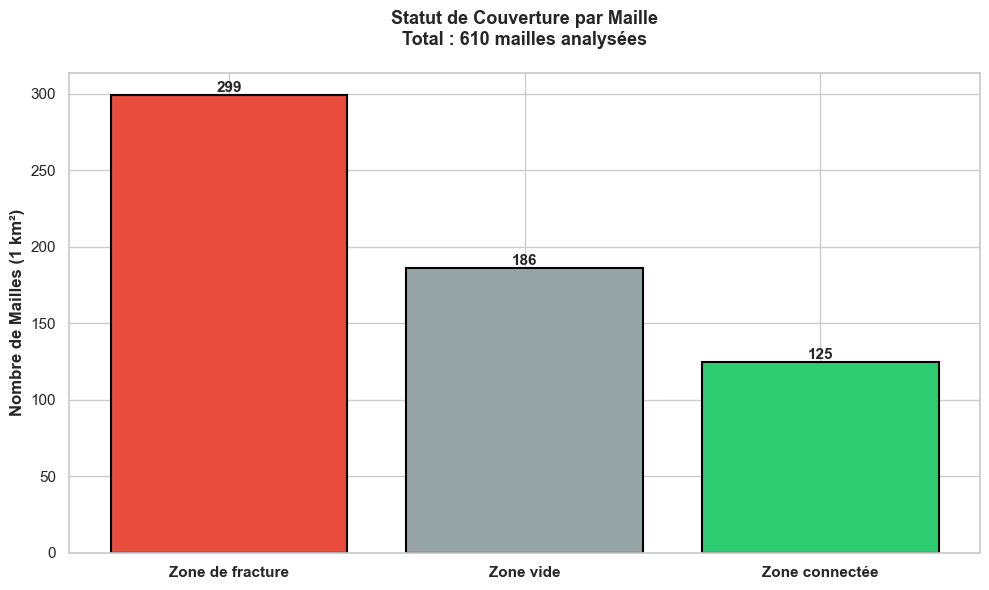

✅ Fig2_Statut_Mailles.png sauvegardée



In [87]:
# Graphique 2 : Statut de couverture par maille
print("\n=== VISUALISATION 2 : Couverture Spatiale (Grille 1 km) ===\n")
fig, ax = plt.subplots(figsize=(10, 6))
status_counts = grid_counts['status'].value_counts()
colors_bar = {'Zone connectée': '#2ecc71', 'Zone de fracture': '#e74c3c', 'Zone vide': '#95a5a6'}
bar_colors = [colors_bar.get(status, '#95a5a6') for status in status_counts.index]

bars = ax.bar(range(len(status_counts)), status_counts.values, color=bar_colors, edgecolor='black', linewidth=1.5)
ax.set_xticks(range(len(status_counts)))
ax.set_xticklabels(status_counts.index, fontsize=11, weight='bold')
ax.set_ylabel("Nombre de Mailles (1 km²)", fontsize=12, weight='bold')
ax.set_title("Statut de Couverture par Maille\n" + 
             f"Total : {len(grid_counts)} mailles analysées", 
             fontsize=13, weight='bold', pad=20)

# Ajouter les valeurs sur les barres
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=11, weight='bold')

plt.tight_layout()
plt.savefig("Fig2_Statut_Mailles.png", dpi=150, bbox_inches='tight')
plt.show()
print("✅ Fig2_Statut_Mailles.png sauvegardée\n")


## Phase 3 : DBSCAN optionnel

- Clustering sur les antennes rapides (Class_A).

- Les antennes 2G/3G hors clusters modernes sont des zones potentiellement oubliées.

- Les hyperparamètres peuvent être ajustés (eps, min_samples).


In [88]:
# DBSCAN sur les antennes rapides (optionnel)

try:

    from sklearn.cluster import DBSCAN

except ImportError:

    DBSCAN = None



slow_outside = pd.DataFrame()

if DBSCAN is None:

    print("scikit-learn manquant : pip install scikit-learn pour activer le clustering.")

else:

    fast = df_clean[df_clean["Tech_Class"] == "Class_A"].copy()

    if len(fast) < 5:

        print("Pas assez d'antennes rapides pour DBSCAN (min 5).")

    else:

        eps_deg = 0.01  # ≈ 1,1 km

        coords = fast[["lon", "lat"]].to_numpy()

        db = DBSCAN(eps=eps_deg, min_samples=5)

        fast["cluster"] = db.fit_predict(coords)



        cluster_centers = (

            fast.loc[fast["cluster"] != -1]

            .groupby("cluster")[ ["lon", "lat"] ]

            .mean()

        )



        slow = df_clean[df_clean["Tech_Class"] == "Class_B"].copy()

        def near_modern(row):

            if cluster_centers.empty:

                return False

            d = np.sqrt(((cluster_centers["lon"] - row["lon"]) ** 2) + ((cluster_centers["lat"] - row["lat"]) ** 2))

            return bool((d <= eps_deg * 1.5).any())



        slow["proche_cluster_modern"] = slow.apply(near_modern, axis=1)

        slow_outside = slow[~slow["proche_cluster_modern"]].copy()



        print("Clusters DBSCAN (hors bruit) :", cluster_centers.shape[0])

        print("Antennes 2G/3G hors clusters modernes :", len(slow_outside))


Clusters DBSCAN (hors bruit) : 13
Antennes 2G/3G hors clusters modernes : 850


## Phase 4 : Visualisation et rapport

- Carte Folium unique (Tanger-Tétouan) avec calques :

  - Grille connectée (vert) et fracture (rouge) sur des calques séparés.

  - Points 2G/3G hors clusters modernes.

  - Points critiques (pas de mise à jour depuis 2020).

- Export HTML unique + statistiques console.


In [89]:
# Carte interactive et rapport

import folium

map_center = [
    grid_counts["centroid_lat"].mean() if not grid_counts.empty else (BBOX["lat_min"] + BBOX["lat_max"]) / 2,
    grid_counts["centroid_lon"].mean() if not grid_counts.empty else (BBOX["lon_min"] + BBOX["lon_max"]) / 2,
]
m = folium.Map(location=map_center, zoom_start=9, tiles="OpenStreetMap")

# Calques
fg_connect = folium.FeatureGroup(name="Zones connectées", show=True)
fg_fracture = folium.FeatureGroup(name="Zones de fracture", show=True)
fg_points = folium.FeatureGroup(name="Antennes 2G/3G hors clusters", show=True)
fg_critiques = folium.FeatureGroup(name="Zones critiques (<2020)", show=True)

status_color = {"Zone connectée": "green", "Zone de fracture": "red"}

for _, row in grid_counts.iterrows():
    if row["status"] == "Zone vide":
        continue
    lon0 = BBOX["lon_min"] + row["grid_x"] * step_lon
    lon1 = lon0 + step_lon
    lat0 = BBOX["lat_min"] + row["grid_y"] * step_lat
    lat1 = lat0 + step_lat
    target_fg = fg_connect if row["status"] == "Zone connectée" else fg_fracture
    folium.Rectangle(
        bounds=[(lat0, lon0), (lat1, lon1)],
        color=status_color.get(row["status"], "gray"),
        weight=1,
        fill=True,
        fill_color=status_color.get(row["status"], "gray"),
        fill_opacity=0.3,
    ).add_to(target_fg)

outdated = pd.DataFrame()
if not slow_outside.empty:
    slow_outside = slow_outside.copy()
    slow_outside["updated_dt"] = pd.to_datetime(slow_outside.get("updated"), unit="s", errors="coerce")
    outdated = slow_outside[slow_outside["updated_dt"] < pd.Timestamp("2020-01-01")]
    for _, row in slow_outside.iterrows():
        folium.CircleMarker(
            location=(row["lat"], row["lon"]),
            radius=4,
            color="red",
            fill=True,
            fill_opacity=0.8,
            popup=f"2G/3G hors cluster, range={row['range']}",
        ).add_to(fg_points)
    for _, row in outdated.iterrows():
        folium.CircleMarker(
            location=(row["lat"], row["lon"]),
            radius=5,
            color="darkred",
            fill=True,
            fill_opacity=0.9,
            popup=f"Zone critique (maj<2020), range={row['range']}",
        ).add_to(fg_critiques)

fg_connect.add_to(m)
fg_fracture.add_to(m)
fg_points.add_to(m)
fg_critiques.add_to(m)
folium.LayerControl().add_to(m)

html_path = Path("tanger_couverture.html")
m.save(html_path)

fracture_cells = (grid_counts["status"] == "Zone de fracture").sum()
connect_cells = (grid_counts["status"] == "Zone connectée").sum()
coverage_base = fracture_cells + connect_cells
pct_fracture = (fracture_cells / coverage_base * 100) if coverage_base else 0

print("--- Statistiques ---")
print(f"Mailles analysées : {len(grid_counts)}")
print(f"Zones fracture (2G/3G sans 4G) : {fracture_cells}")
print(f"Zones connectées (mix 2G/4G) : {connect_cells}")
print(f"Part des zones couvertes uniquement en 2G/3G : {pct_fracture:.1f}%")
print(f"Antennes à moderniser (hors clusters modernes) : {len(slow_outside)}")
print(f"Zones critiques (<2020) : {len(outdated)}")
print(f"Carte HTML : {html_path.resolve() if html_path.exists() else html_path}")

# Export des points noirs prioritaires
if not slow_outside.empty:
    export_cols = [c for c in ["radio", "mcc", "mnc", "network", "lat", "lon", "range", "updated", "Tech_Class"] if c in slow_outside.columns]
    blacklist = slow_outside.copy()
    blacklist["updated"] = pd.to_datetime(blacklist.get("updated"), unit="s", errors="coerce")
    blacklist = blacklist.sort_values("updated", ascending=False)
    blacklist[export_cols].to_csv("Rapport_Zones_A_Moderniser.csv", index=False)
    print(f"Fichier d'intervention généré avec {len(blacklist)} antennes critiques.")
else:
    print("Aucune antenne hors cluster rapide : pas d'export CSV.")


--- Statistiques ---
Mailles analysées : 610
Zones fracture (2G/3G sans 4G) : 299
Zones connectées (mix 2G/4G) : 125
Part des zones couvertes uniquement en 2G/3G : 70.5%
Antennes à moderniser (hors clusters modernes) : 850
Zones critiques (<2020) : 769
Carte HTML : D:\GIS_fst\Algorithmique - programmation\project\tanger_couverture.html
Fichier d'intervention généré avec 850 antennes critiques.


In [ ]:
# Stats par opérateur (MNC)

if "mnc" in df_clean.columns:
    operateurs = {1: "Maroc Telecom (IAM)", 0: "Orange", 2: "Orange", 5: "Inwi"}
    summary = (
        df_clean.groupby(["mnc", "Tech_Class"]).size()
        .unstack(fill_value=0)
        .rename(columns={"Class_A": "count_A", "Class_B": "count_B"})
        .reset_index()
    )
    summary["operator"] = summary["mnc"].map(operateurs).fillna("Autre")
    summary["total"] = summary["count_A"] + summary["count_B"]
    summary["pct_modern"] = (summary["count_A"] / summary["total"] * 100).round(1)
    summary = summary.sort_values("pct_modern", ascending=False)

    print("--- Couverture par opérateur (antennes actives dans la bbox) ---")
    print(summary[["operator", "mnc", "count_A", "count_B", "total", "pct_modern"]])
else:
    print("⚠️ Colonne MNC absente : statistiques opérateur non disponibles.")


--- Couverture par opérateur (antennes actives dans la bbox) ---
Tech_Class             operator  mnc  count_A  count_B  total  pct_modern
1           Maroc Telecom (IAM)    1      413      656   1069        38.6
0                        Orange    0       52      129    181        28.7
2                        Orange    2       54      211    265        20.4



=== VISUALISATION 3 : Comparaison Opérateurs (Déploiement 4G/5G) ===



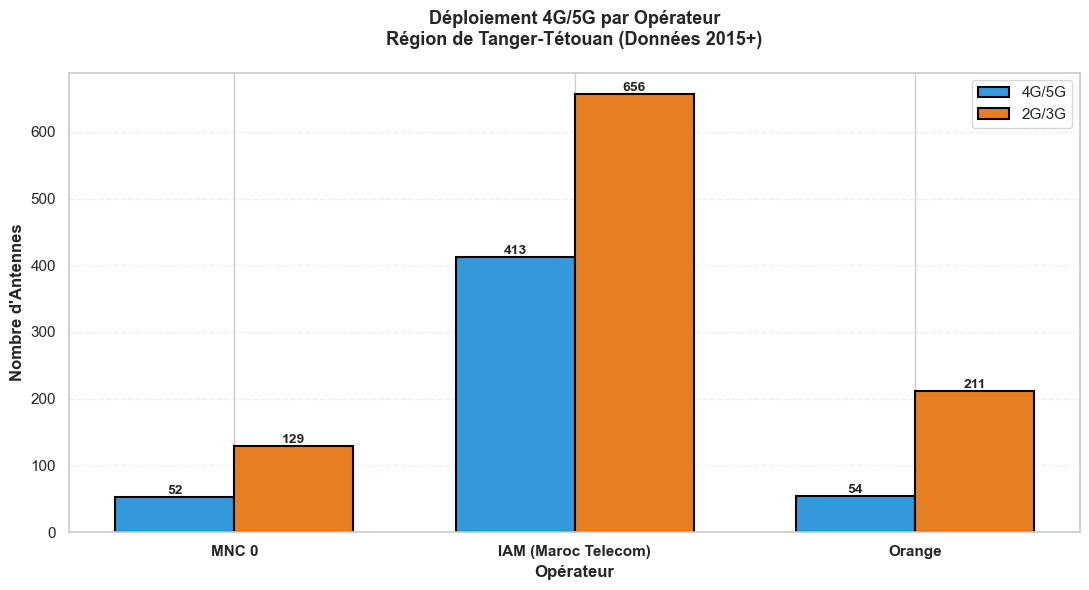

✅ Fig3_Operateurs_Comparaison.png sauvegardée



In [91]:
# Graphique 3 : Comparaison des opérateurs
print("\n=== VISUALISATION 3 : Comparaison Opérateurs (Déploiement 4G/5G) ===\n")

# Agrégation par opérateur et technologie
df_op = df_clean.groupby(['mnc', 'Tech_Class']).size().unstack(fill_value=0)
df_op['Total'] = df_op.sum(axis=1)

# Mapper les codes MNC aux noms
mnc_map = {1: 'IAM (Maroc Telecom)', 2: 'Orange', 5: 'Inwi'}
df_op.index = df_op.index.map(lambda x: mnc_map.get(x, f'MNC {x}'))

# Créer le graphique
fig, ax = plt.subplots(figsize=(11, 6))
x_pos = range(len(df_op))
width = 0.35

# Barres pour 4G/5G vs 2G/3G
fast_counts = df_op.get('Class_A', [0] * len(df_op))
slow_counts = df_op.get('Class_B', [0] * len(df_op))

bars1 = ax.bar([p - width/2 for p in x_pos], fast_counts, width, label='4G/5G', color='#3498db', edgecolor='black', linewidth=1.5)
bars2 = ax.bar([p + width/2 for p in x_pos], slow_counts, width, label='2G/3G', color='#e67e22', edgecolor='black', linewidth=1.5)

ax.set_xlabel("Opérateur", fontsize=12, weight='bold')
ax.set_ylabel("Nombre d'Antennes", fontsize=12, weight='bold')
ax.set_title("Déploiement 4G/5G par Opérateur\n" +
             f"Région de Tanger-Tétouan (Données {ACTIVE_YEAR_MIN}+)", 
             fontsize=13, weight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(df_op.index, fontsize=11, weight='bold')
ax.legend(fontsize=11, loc='upper right')
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Ajouter valeurs sur barres
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}',
                    ha='center', va='bottom', fontsize=10, weight='bold')

plt.tight_layout()
plt.savefig("Fig3_Operateurs_Comparaison.png", dpi=150, bbox_inches='tight')
plt.show()
print("✅ Fig3_Operateurs_Comparaison.png sauvegardée\n")



=== VISUALISATION 4 : Évolution Temporelle des Antennes ===



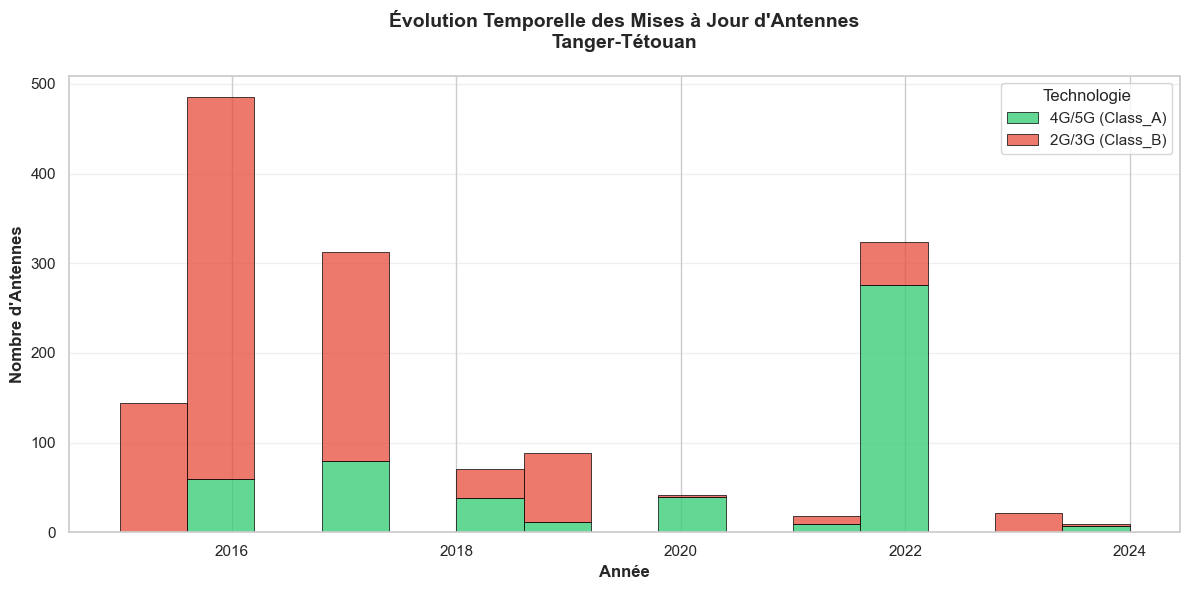

✅ Fig4_Evolution_Temporelle.png sauvegardée

--- Statistiques Temporelles ---
Antennes les plus récentes (2020+) : 414
Antennes anciennes (avant 2015) : 0


In [92]:
# Graphique 4 : Évolution temporelle des mises à jour
print("\n=== VISUALISATION 4 : Évolution Temporelle des Antennes ===\n")

# Extraction de l'année depuis le timestamp Unix
df_clean['Annee'] = pd.to_datetime(df_clean['updated'], unit='s', errors='coerce').dt.year

# Filtrage des données aberrantes (garder 2010-2026)
df_time = df_clean[(df_clean['Annee'] >= 2010) & (df_clean['Annee'] <= 2026)].copy()

# Générer le graphique
plt.figure(figsize=(12, 6))
sns.histplot(
    data=df_time, 
    x="Annee", 
    hue="Tech_Class", 
    multiple="stack", 
    bins=15, 
    palette={"Class_A": "#2ecc71", "Class_B": "#e74c3c"},
    edgecolor='black',
    linewidth=0.5
)
plt.title("Évolution Temporelle des Mises à Jour d'Antennes\nTanger-Tétouan", 
          fontsize=14, weight='bold', pad=20)
plt.xlabel("Année", fontsize=12, weight='bold')
plt.ylabel("Nombre d'Antennes", fontsize=12, weight='bold')
plt.legend(title="Technologie", labels=["4G/5G (Class_A)", "2G/3G (Class_B)"])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

# Sauvegarde du fichier
plt.savefig("Fig4_Evolution_Temporelle.png", dpi=150, bbox_inches='tight')
plt.show()
print("✅ Fig4_Evolution_Temporelle.png sauvegardée\n")

# Statistiques temporelles
print("--- Statistiques Temporelles ---")
print(f"Antennes les plus récentes (2020+) : {len(df_time[df_time['Annee'] >= 2020])}")
print(f"Antennes anciennes (avant 2015) : {len(df_time[df_time['Annee'] < 2015])}")
